In [1]:
#from train import  reward
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import math
#from trading_bot.ops import calcRewardLine
from scipy.special import expit
from trading_bot.ops import calcRewardExp
from trading_bot.utils import (
    get_stock_data,
    format_currency,
    format_position,
    show_train_result,
    switch_k_backend_device,
    readData,
    prepareData,
    readFinam,
    prepAtr,
)
from trading_bot.ops import fractalsExp
from trading_bot.utils import Data

In [2]:
def sigmoid(x):
    """Performs sigmoid operation
    """
    # return 1 - 1 / (1 + math.exp(x))
    return 1 / (1 + math.exp(-x))

def reward(dealPrice,curPrice): #,slpow,sl
    d = (curPrice-dealPrice)/dealPrice if dealPrice >=0 else (-1*dealPrice - curPrice)/(-1*dealPrice)
    return 1 + (0.25)/(-d-0.5) if d>=0 else (.088)/(.5-2.718281**(d*10-1))-0.17
b = 100
x = np.linspace(-1000,1000,100)
#y = np.array(list(map(lambda k: calcRewardLine(-b,b*k),x)))
y1 = np.array(list(map(lambda k: calcRewardExp(b,b*k),x)))
y3 = np.array(list(map(lambda k: reward(b,b*k),x)))
tmp = np.array(list(map(lambda k: (b-b*k)/b,x)))
y4 = np.tanh(x*10+0.9)
# ySigmoid = np.array(list(map(sigmoid,x)))
# y6 = np.array(list(map(lambda k:(1 / (1 + math.exp(-k))) ,x)))
yExpit = np.array(list(map(expit ,x)))


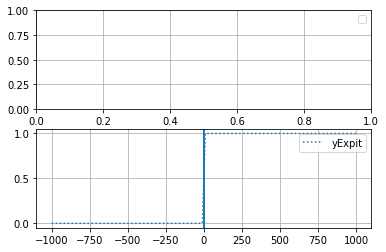

In [3]:
fig,(ax0,ax1) = plt.subplots(2,1)
#plt.plot((x),y)
#plt.plot((x),y1)
# ax0.plot(x,ySigmoid, label='ySigmoid')
# plt.plot(x,y6)
ax1.plot(x,yExpit, linestyle='dotted', label='yExpit')
ax0.grid()
ax0.legend()
ax1.grid()
ax1.legend()
xcoords = [-0.05, 0, 0.05]
for xc in xcoords:
    plt.axvline(x=xc)

In [5]:
np.array(map(lambda k: reward(1,1+k),x))

array(<map object at 0x000001FE34022CD0>, dtype=object)

## Test

In [2]:
# Prepare

def prep(df,window_size=16):
    df['MA'] = df['Close'].rolling(window = 233).mean()
    # df['CloseMAABS'] = df.Close - df.MA
    # df['CloseMAAT'] = df.CloseMAABS / df.MA
    # df['CloseMAATEXP'] = expit(df.CloseMAAT)

    df['FH'] = [fractalHigh(fractalHigh(win)) for win in df.High.rolling(window=800)]
    # df['FH'] = df.FH.map(lambda x: x[:window_size])
    for row in df.itertuples(): row.FH.index = row.FH.index +pd.Timedelta(microseconds=1)
    df['FHAT'] = ((df.FH - df.MA) / df.MA)
    df['FHATEXP'] = df.FHAT.map(expit)

    df['FL'] = [fractalLow(fractalLow(win)) for win in df.Low.rolling(window=800)]
    # df['FL'] = df.FL.map(lambda x: x[:window_size])
    df['FLAT'] = ((df.FL - df.MA) / df.MA)
    df['FLATEXP'] = df.FLAT.map(expit)


    df['MIX'] =[ pd.concat([row.FHATEXP,row.FLATEXP]).sort_index() for row in df.itertuples()]
    df['MIX'] = df.MIX.map(lambda x: x[-window_size:])

    return df


In [3]:
def fractalHigh(d):
    # for _ in range(3):
     return d.where(((d >= d.shift(1)) & (d  >= d.shift(2))
                    & (d > d.shift(-1)) & (d  > d.shift(-2)))
                 # ,True, False)
                 ).dropna()
    # return d
def fractalLow(d):
    return d.where((d < d.shift(1)) & (d < d.shift(2))
                   & (d <= d.shift(-1)) & (d <= d.shift(-2))
                # ,True, False
                ).dropna()

In [4]:
class Data1(Data):
    def _prepareDf(self):
        self.df = prep(self.df,window_size=16)
        prepAtr(self.df)
        self.ver = 'v02'
        self.description = 'Fractals 2 level MA AT EXP window_size=16'
    def getState(self,t,*args,iloc=True,**kwargs):
        return np.array(super().getState(t,*args,iloc=True,**kwargs).MIX)

In [12]:
%%time
# Read data
# df = readFinam('SBER',r'Z:\finam\data',tFrame='minute',dFrom=pd.Timestamp('2022-01-20'),dTo=pd.Timestamp('2022-01-30'))
# df = pd.read_csv(r'C:\share\stock\SBER_2014.csv', index_col=['Date'], parse_dates=['Date'], skiprows=range(1, 1),nrows=None) #
data = Data1(r'C:\share\stock\SBER_2022.csv',tik='SBER',tFrame='minute',dFrom=pd.Timestamp('2022-01-20'),dTo=pd.Timestamp('2022-01-30'))
window_size = 16
print(f'{data.df.shape}, {data.df.columns}, {data}')

(6937, 15), Index(['Open', 'High', 'Low', 'Close', 'Volume', 'MA', 'FH', 'FHAT', 'FHATEXP',
       'FL', 'FLAT', 'FLATEXP', 'MIX', 'TR', 'ATR'],
      dtype='object'), vd0_SBER
CPU times: total: 27.9 s
Wall time: 27.9 s


In [15]:
from trading_bot.ops import OHLCVtoSeries,fractalsExp
data.df['MIX1'] = [OHLCVtoSeries(fractalsExp(win, 3))for win in data.df.rolling(window=800)]
# OHLCVtoSeries(fractalsExp(win, 3))

In [17]:
data.df.MIX1.iloc[2000]

Date
2022-01-21 12:01:00    249.71
2022-01-21 12:36:00    253.91
2022-01-21 13:21:00    253.87
2022-01-21 14:46:00    246.00
2022-01-21 15:11:00    259.08
2022-01-21 15:33:00    252.86
2022-01-21 17:39:00    252.95
2022-01-21 18:25:00    246.27
2022-01-21 18:38:00    248.62
2022-01-21 19:23:00    249.99
2022-01-21 19:43:00    247.63
2022-01-21 19:58:00    248.78
2022-01-21 20:24:00    248.00
2022-01-21 20:50:00    248.99
2022-01-21 21:07:00    247.60
2022-01-21 21:47:00    248.94
2022-01-24 07:01:00    245.15
Name: High, dtype: float64

In [238]:
%%time

df = prep(df)

df['FH'] = [fractalHigh(fractalHigh(win)) for win in df.High.rolling(window=800)]
# df['FH'] = df.FH.map(lambda x: x[:window_size])
for row in df.itertuples(): row.FH.index = row.FH.index +pd.Timedelta(microseconds=1)
df['FHAT'] = ((df.FH - df.MA) / df.MA)
df['FHATEXP'] = df.FHAT.map(expit)

df['FL'] = [fractalLow(fractalLow(win)) for win in df.Low.rolling(window=800)]
# df['FL'] = df.FL.map(lambda x: x[:window_size])
df['FLAT'] = ((df.FL - df.MA) / df.MA)
df['FLATEXP'] = df.FLAT.map(expit)


df['MIX'] =[ pd.concat([row.FHATEXP,row.FLATEXP]).sort_index() for row in df.itertuples()]
df['MIX'] = df.MIX.map(lambda x: x[-window_size:])

CPU times: total: 12.1 s
Wall time: 12.4 s


[<AxesSubplot:>, ['MIX', 'FHATEXP', 'FLATEXP']]
MIX:0
FHATEXP:0
FLATEXP:0
[<AxesSubplot:>, ['MIX', 'FHATEXP', 'FLATEXP']]
MIX:1
FHATEXP:1
FLATEXP:1
[<AxesSubplot:>, ['MIX', 'FHATEXP', 'FLATEXP']]
MIX:2
FHATEXP:2
FLATEXP:2


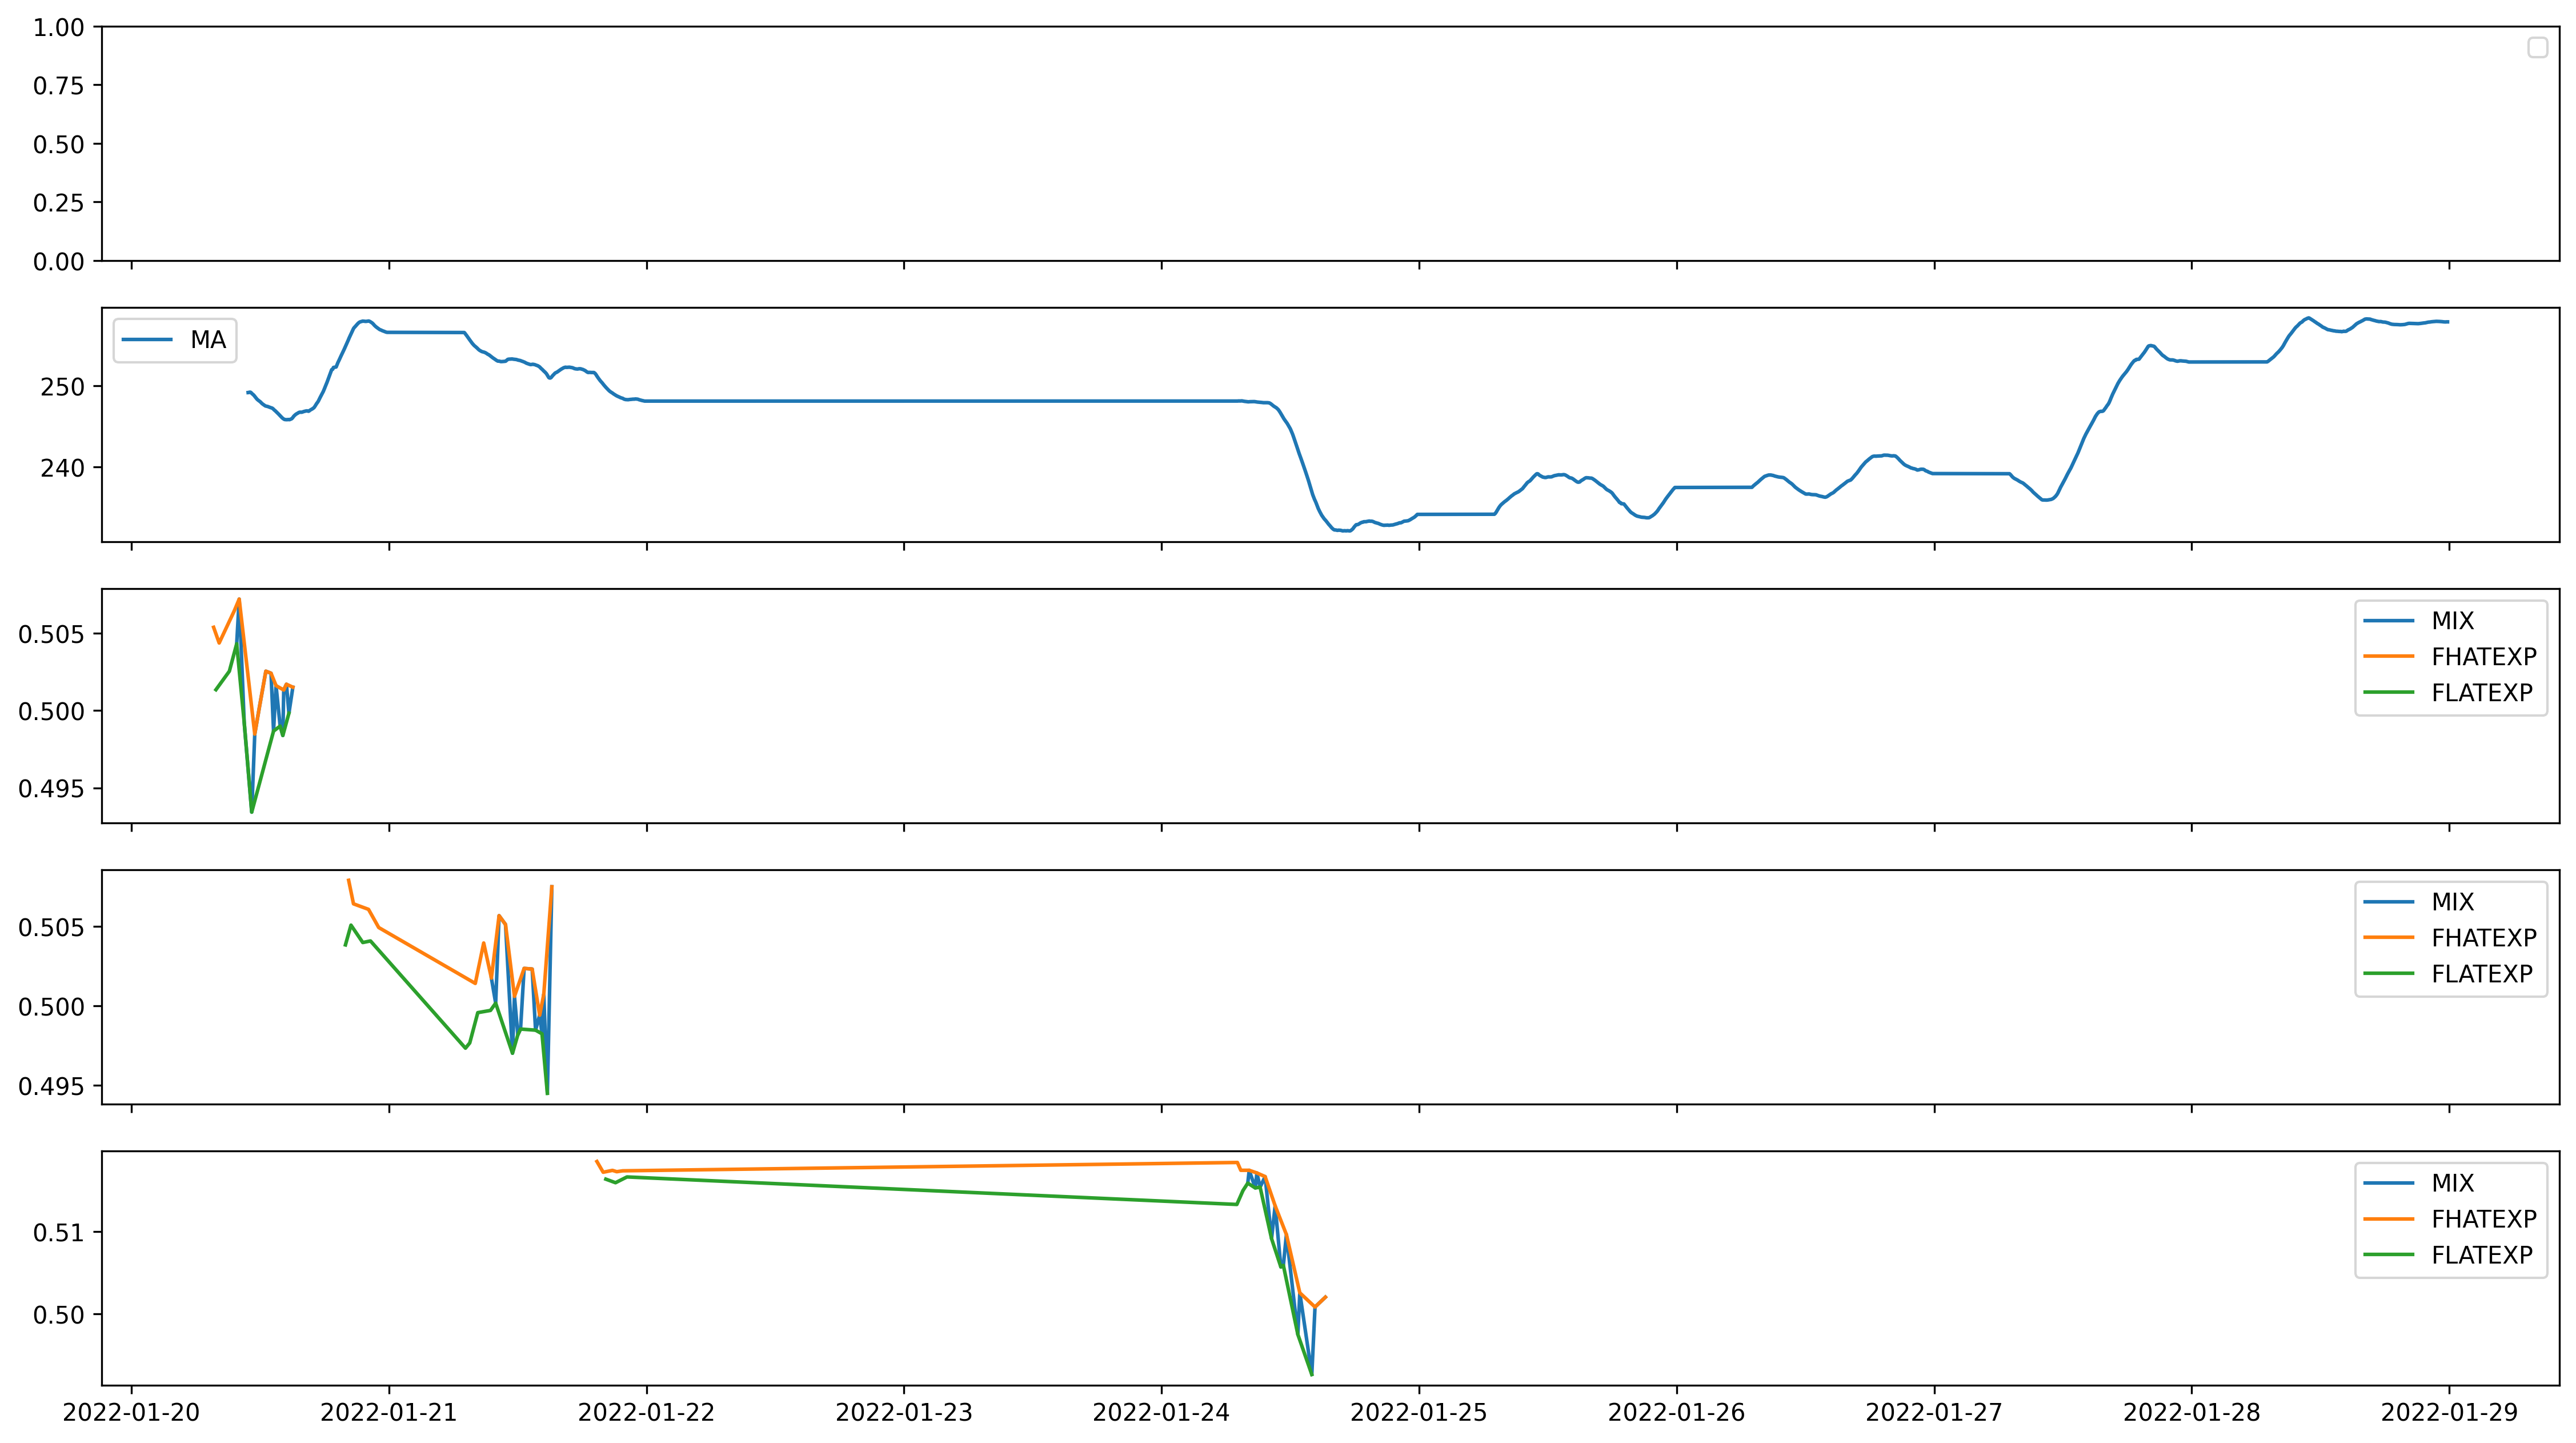

In [22]:
df = data.df
# from matplotlib.pyplot import figure
# figure(figsize=(32, 16), dpi=400)
fig,(ax1,ax2,axI1,axI2,axI3) = plt.subplots(5,1,sharex=True)
fig.set_dpi(300)
fig.set_size_inches(18.5, 10.5)
# ax.plot(df.High)
# ax1.plot(df.index,df.CloseMAATEXP,label='MA')
# ax1.plot(df.index,df.MAEXP,label='MAEXP')
# ax.plot(dff.MAFHAT)
# ax1.plot(dff.index,dff.MAFHATEXP,label='MAFHATEXP')
ax1.legend()
ax2.plot(df.index,df.MA,label='MA')
ax2.legend()
# df['MAID']=np.nan
for i,ax in enumerate(([axI1,['MIX','FHATEXP','FLATEXP']],[axI2,['MIX','FHATEXP','FLATEXP']],[axI3,['MIX','FHATEXP','FLATEXP',]])):
    print(ax)
    for s in ax[1]:
        print(f'{s}:{i}')
        ax[0].plot(df[s].iloc[i*1000+500], label=df[s].name)
    ax[0].legend()

# plt.show()

In [235]:
df.loc[df.index[2000],['MIX','FHATEXP']]


MIX        Date
2014-01-09 13:20:00.000001    0.500688
20...
FHATEXP    Date
2014-01-09 13:20:00.000001    0.500688
20...
Name: 2014-01-10 17:21:00, dtype: object

In [51]:
from qbroker.broker import CommInfoBase
comm = CommInfoBase(commission=0.1, )
comm.params

In [183]:
n = 'MA'
df[n].name

'MA'

In [149]:
df.loc[df.index[1000],"MIX"] = pd.Series([1,2,3])
df.loc[df.index[1000]].MIX
#df.loc[df.index[1000],['MIX']] = pd.Series(pd.concat([df.FH[1000][:window_size],df.FL[1000][:window_size]]))

ValueError: Incompatible indexer with Series

In [223]:
def f(fl,fh):
    return pd.concat([fl[:window_size],fh[:window_size]])
df.apply(lambda row: row["MIX"] = f(row["FL"],row["FH"]),axis=1)

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (3973544777.py, line 3)

In [117]:
df['MIX'] = pd.concat([df.FH.map(lambda x: x.index+pd.Timedelta(seconds=1)),df.FL])

C:\Users\ivank\AppData\Local\Temp\ipykernel_20320\1765833030.py:1: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  df['MIX'] = pd.concat([df.FH.map(lambda x: x.index+pd.Timedelta(seconds=1)),df.FL])


ValueError: cannot reindex on an axis with duplicate labels

In [59]:
pos = -1
(pos + abs(-pos))//2

0

In [1]:
from trading_bot.utils import Data
from qbroker.broker import qbroker
from qbroker.broker import TradeBase

import pandas as pd
import matplotlib.pyplot as plt

class Data1(Data):
    def _prepareDf(self):
        self.df['MA'] = self.df['Close'].rolling(window = 233).mean()
        self.df['TR'] = self.df['High'] - self.df['Low']
        self.df['ATR'] = self.df['TR'].rolling(window=13).mean()


data = Data1(r'C:\share\stock\SBER_2022.csv',tik='SBER',tFrame='minute',dFrom=pd.Timestamp('2022-01-20'),dTo=pd.Timestamp('2022-01-30'))

In [3]:
%%time
from qbroker.broker import Position
t = TradeBase(price=-1,tp=4,sl=-8)
p =
bro = qbroker()
for i in range(20):
    data.next(iloc=i*(6500//20))
    res = bro.calcTrade(data, t)
    print(f'{data.loc} , res:{res:.4f}')

2022-01-20 07:01:00 , res:1.0000
2022-01-20 12:26:00 , res:1.0400
2022-01-20 17:51:00 , res:0.9886
2022-01-20 23:35:00 , res:0.9967
2022-01-21 12:10:00 , res:0.9862
2022-01-21 17:35:00 , res:0.9815
2022-01-21 23:19:00 , res:0.9932
2022-01-24 11:54:00 , res:0.9791
2022-01-24 17:19:00 , res:1.0400
2022-01-24 23:03:00 , res:0.9917
2022-01-25 11:38:00 , res:1.0400
2022-01-25 17:03:00 , res:0.9830
2022-01-25 22:47:00 , res:0.9855
2022-01-26 11:22:00 , res:1.0400
2022-01-26 16:47:00 , res:0.9837
2022-01-26 22:31:00 , res:0.9861
2022-01-27 11:06:00 , res:1.0000
2022-01-27 16:31:00 , res:1.0023
2022-01-27 22:15:00 , res:1.0182
2022-01-28 10:50:00 , res:1.0081
CPU times: total: 78.1 ms
Wall time: 62 ms


In [11]:
from qbroker.broker import Position
p = dict(SBER=Position())
p.get('SBER').price and True

0.0

In [10]:
p.price

AttributeError: 'dict' object has no attribute 'price'